In [ ]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    log_loss,
)
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


# ===========================
# 🩸 ANEMIA DATA PREPARATION + EDA
# ===========================

df = pd.read_csv("/content/Anemia-Dataset-Final.csv")

# --- BASIC EXPLORATORY DATA ANALYSIS ---
print("\n🔍 Basic EDA Summary")
print("===================================")
print("🧾 Dataset Preview:")
print(df.head(), "\n")

print("📏 Dataset Shape:", df.shape)
print("\n📂 Column Data Types and Non-Null Counts:")
print(df.info(), "\n")

# Check duplicates
duplicates_count = df.duplicated().sum()
print(f"🔁 Duplicate Rows: {duplicates_count}")

# Check missing/null values
print("\n🚫 Missing Values per Column:")
print(df.isnull().sum(), "\n")

# Quick descriptive statistics for numeric columns
print("📊 Statistical Summary of Numeric Columns:")
print(df.describe().T)
print("===================================\n")


# ===========================
# 🔧 DATA CLEANING
# ===========================

# Clean gender/category values
df['GENDER'] = df['GENDER'].astype(str).str.strip().str.upper().replace({'FEMALE': 'F', 'MALE': 'M'})
df['CATEGORY'] = df['CATEGORY'].astype(str).str.strip().str.capitalize()

# Keep valid entries only
df = df[df['GENDER'].isin(['M', 'F'])]
df = df[df['CATEGORY'].isin(['Normal', 'Mild', 'Moderate', 'Severe'])]

# Convert numerical columns safely
for col in df.columns:
    if col not in ['GENDER', 'CATEGORY']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop duplicates and rows with too many missing CBC features
df = df.drop_duplicates()
df = df.dropna(thresh=df.shape[1] - 3)

print("✅ Final cleaned dataset shape:", df.shape)

# Encode gender
le = LabelEncoder()
df['GENDER'] = le.fit_transform(df['GENDER'])

# --- Add a physiologically meaningful feature ---
# MCH (Mean Corpuscular Hemoglobin) = (Hemoglobin * 10) / RBC
# Helps strengthen the natural correlation between RBC, Hemoglobin, and Hematocrit
if all(col in df.columns for col in ['RBC', 'Hemoglobin']):
    df['MCH'] = (df['Hemoglobin'] * 10) / df['RBC']

# Imputation and scaling
X = df.drop('CATEGORY', axis=1)
y = df['CATEGORY']

le_category = LabelEncoder()
y = le_category.fit_transform(y)

# Median imputation for robustness
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# PowerTransform (Yeo-Johnson) reduces skewness, improving correlations
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X_scaled = scaler.fit_transform(X_imputed)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

# Rebuild DataFrame for correlation visualization
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)



🔍 Basic EDA Summary
🧾 Dataset Preview:
    AGE GENDER    WBC   RBC  HEMOGLOBIN  HEMATOCRIT   MCV   MCH  MCHC  \
0  54.0      F   8.23  3.56        11.1        34.0  95.5  31.2  32.6   
1  78.0      M  10.80  9.73        13.1        42.0  88.8  27.7  31.2   
2  15.0      M   3.29  4.61        13.4        43.0  93.3  29.1  31.2   
3   6.0      M   1.94  4.06        11.3        86.0  88.7  27.8  31.4   
4   9.0      F   3.13  4.04        10.7        33.7  83.4  26.5  31.8   

   PLATELET  NEUTROPHILS  LYMPHOCYTES  MONOCYTES  EUSONIPHILS  BASOPHIL  \
0     321.0         59.6         28.1        9.7          2.2       0.6   
1     225.0         56.8         29.4       12.0          0.8       1.0   
2     103.0         64.5         39.2        3.6          2.4       0.3   
3     153.0         15.0         70.1        9.8          3.6       1.5   
4     143.0         40.8         44.7       10.7          3.5       0.3   

   IMMATURE_GRANULYTES CATEGORY  
0                 0.10     Mild  
1 


📊 Exploratory Data Analysis (EDA)


/tmp/ipython-input-3318134533.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='CATEGORY', data=eda_df, ax=axes[0], palette='Set2')
/tmp/ipython-input-3318134533.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='GENDER', data=eda_df, ax=axes[1], palette='Set1')


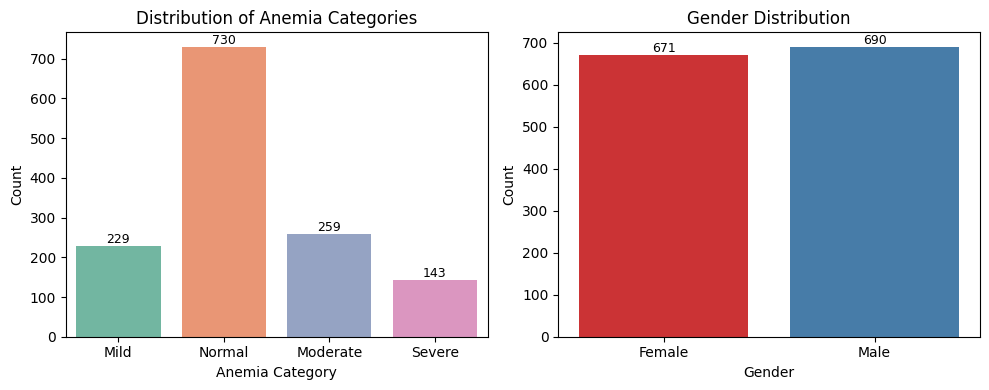

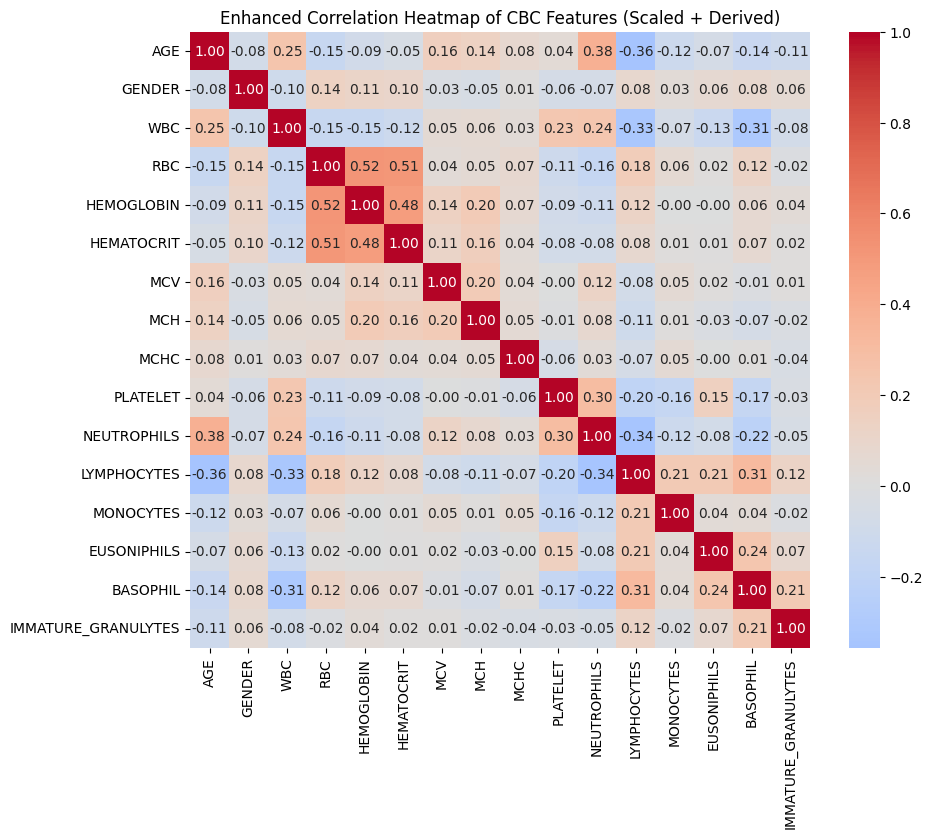

In [ ]:
# ===================== 3. EXPLORATORY DATA ANALYSIS (EDA) =====================
print("\n📊 Exploratory Data Analysis (EDA)")

eda_df = df.copy()
eda_df['GENDER'] = eda_df['GENDER'].replace({1: 'Male', 0: 'Female'})

# --- Distribution Plots ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(x='CATEGORY', data=eda_df, ax=axes[0], palette='Set2')
axes[0].set_title('Distribution of Anemia Categories')
axes[0].set_xlabel('Anemia Category')
axes[0].set_ylabel('Count')
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}', (p.get_x()+p.get_width()/2., p.get_height()),
                     ha='center', va='bottom', fontsize=9)

sns.countplot(x='GENDER', data=eda_df, ax=axes[1], palette='Set1')
axes[1].set_title('Gender Distribution')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_height())}', (p.get_x()+p.get_width()/2., p.get_height()),
                     ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(10, 8))
corr = df_scaled.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Enhanced Correlation Heatmap of CBC Features (Scaled + Derived)")
plt.show()


In [ ]:
# ===================== 4. Initialize Models =====================
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=7, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        objective='multi:softmax', num_class=len(np.unique(y_res))
    ),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42)
}

results = []
conf_matrices = {}

In [ ]:
# ===================== 5b. Model Evaluation + Store Predictions/Probas =====================
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = []
conf_matrices = {}
reports = {}
predict_times = {}
model_store = []  # <-- store trained models and their predictions

for name, model in models.items():
    print(f"\n🚀 Evaluating {name}...")

    # --- Training ---
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0

    # --- Inference ---
    t1 = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - t1

    # --- Probabilities (if available) ---
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        train_loss = log_loss(y_train, model.predict_proba(X_train))
        val_loss = log_loss(y_test, y_proba)
    else:
        y_proba = None
        train_loss = val_loss = np.nan

    # --- Store trained model + predictions/probas ---
    model_store.append({
        "name": name,
        "model": model,
        "y_pred": y_pred,
        "y_proba": y_proba
    })

    # --- Metrics ---
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_test, y_pred)

    # Standard metrics
    prec_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    prec_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    reports[name] = report

    # Cross-validation
    cv_scores = cross_val_score(model, X_res, y_res, cv=cv, scoring='accuracy', n_jobs=-1)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices[name] = cm

    # Model size
    temp_path = f"{name}_temp_model.pkl"
    joblib.dump(model, temp_path)
    model_size = os.path.getsize(temp_path) / (1024*1024)
    os.remove(temp_path)

    # Store results
    results.append({
        'Model': name,
        'Average Training Accuracy': train_acc,
        'Average Training Loss': train_loss,
        'Average Validation Accuracy': val_acc,
        'Average Validation Loss': val_loss,
        'Test Accuracy': val_acc,
        'Precision (weighted)': prec_weighted,
        'Recall (weighted)': rec_weighted,
        'F1 (weighted)': f1_weighted,
        'Precision (macro)': prec_macro,
        'Recall (macro)': rec_macro,
        'F1 (macro)': f1_macro,
        'Mean CV Accuracy': np.mean(cv_scores),
        'CV Std': np.std(cv_scores),
        'Training Time (s)': train_time,
        'Inference Time (s)': pred_time,
        'Model Size (MB)': model_size
    })

    predict_times[name] = pred_time
    print(f"✅ {name}: Val Acc={val_acc:.4f} | Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f}")

# --- Convert results to DataFrame ---
results_df = pd.DataFrame(results)
cols_order = [
    'Model',
    'Average Training Accuracy', 'Average Training Loss',
    'Average Validation Accuracy', 'Average Validation Loss',
    'Test Accuracy',
    'Precision (weighted)', 'Recall (weighted)', 'F1 (weighted)',
    'Precision (macro)', 'Recall (macro)', 'F1 (macro)',
    'Mean CV Accuracy', 'CV Std',
    'Training Time (s)', 'Inference Time (s)', 'Model Size (MB)'
]
results_df = results_df[cols_order]
display(results_df.sort_values(by='Mean CV Accuracy', ascending=False))



🚀 Evaluating Decision Tree...
✅ Decision Tree: Val Acc=0.5274 | Train Loss=0.9220 | Val Loss=2.6188

🚀 Evaluating Random Forest...
✅ Random Forest: Val Acc=0.7192 | Train Loss=0.5280 | Val Loss=0.9018

🚀 Evaluating XGBoost...
✅ XGBoost: Val Acc=0.7500 | Train Loss=0.1084 | Val Loss=0.7050

🚀 Evaluating Logistic Regression...
✅ Logistic Regression: Val Acc=0.3579 | Train Loss=1.3215 | Val Loss=1.3102

🚀 Evaluating SVM...
✅ SVM: Val Acc=0.5976 | Train Loss=0.8417 | Val Loss=0.9637


,Model,Average Training Accuracy,Average Training Loss,Average Validation Accuracy,Average Validation Loss,Test Accuracy,Precision (weighted),Recall (weighted),F1 (weighted),Precision (macro),Recall (macro),F1 (macro),Mean CV Accuracy,CV Std,Training Time (s),Inference Time (s),Model Size (MB)
2,XGBoost,0.976455,0.108428,0.750000,0.704987,0.750000,0.755181,0.750000,0.751305,0.755181,0.750000,0.751305,0.764041,0.027459,2.214262,0.018129,2.163223
1,Random Forest,0.961901,0.528004,0.719178,0.901846,0.719178,0.716112,0.719178,0.716255,0.716112,0.719178,0.716255,0.729110,0.034262,4.569587,0.077981,8.762139
4,SVM,0.683219,0.841736,0.597603,0.963675,0.597603,0.592736,0.597603,0.589759,0.592736,0.597603,0.589759,0.601027,0.019569,2.665514,0.135087,0.373778
0,Decision Tree,0.627140,0.921979,0.527397,2.618849,0.527397,0.531319,0.527397,0.524613,0.531319,0.527397,0.524613,0.522603,0.033033,0.098254,0.000879,0.016366
3,Logistic Regression,0.367723,1.321468,0.357877,1.310193,0.357877,0.356883,0.357877,0.356478,0.356883,0.357877,0.356478,0.365411,0.030014,0.013294,0.000572,0.001349


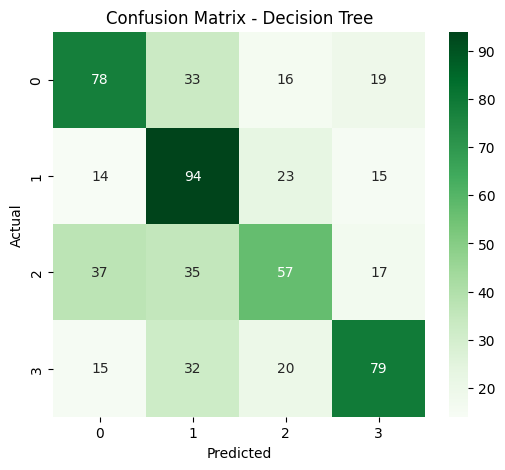

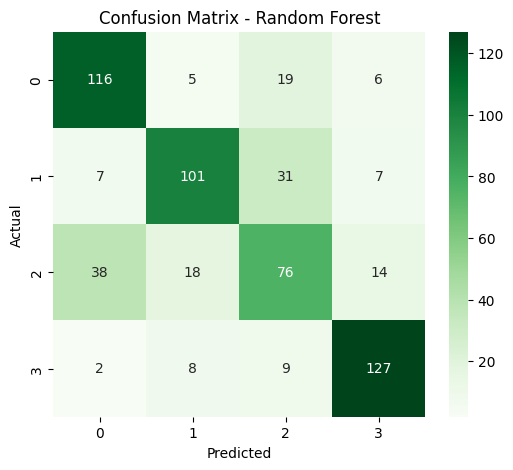

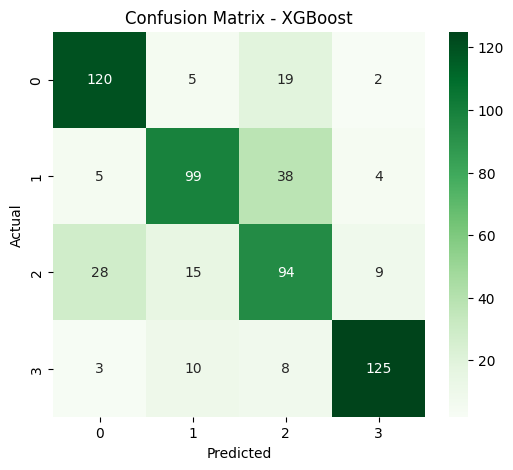

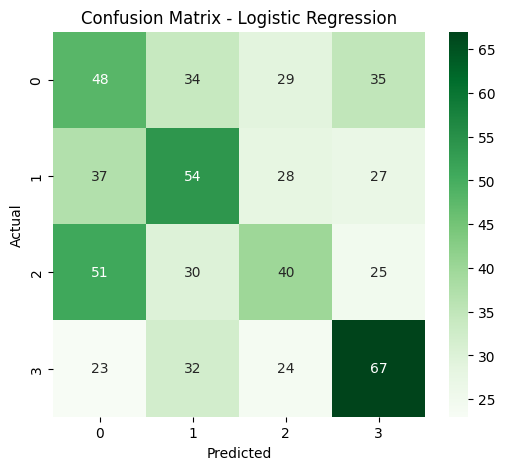

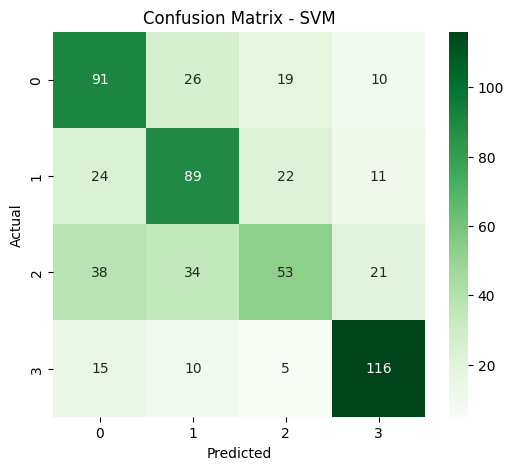

In [ ]:
for name, cm in conf_matrices.items():
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=np.unique(y_res), yticklabels=np.unique(y_res))
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


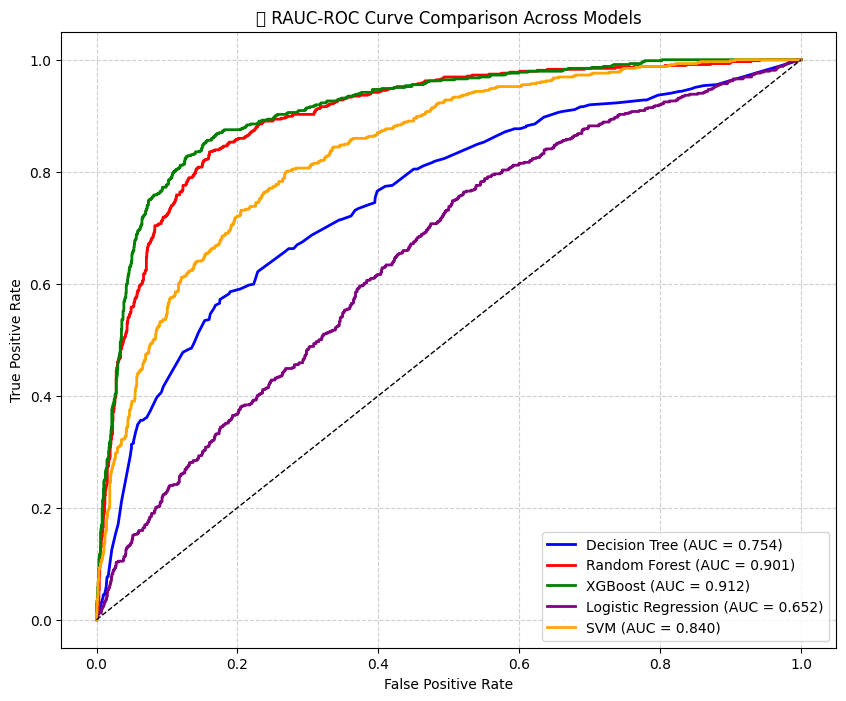

In [ ]:
# ===================== 6. ROC–AUC Visualization (using model_store) =====================
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

# --- Binarize test labels for multi-class ROC ---
n_classes = len(np.unique(y_res))
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])

# --- Loop through all models stored in model_store ---
for entry, color in zip(model_store, colors):
    name = entry['name']
    y_proba = entry['y_proba']

    if y_proba is None:
        print(f"⚠️ Skipping {name}: no probability output available.")
        continue

    # Compute ROC curve and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot micro-average ROC
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f'{name} (AUC = {roc_auc["micro"]:.3f})',
        color=color,
        linewidth=2,
    )

# --- Random baseline ---
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('📈 RAUC-ROC Curve Comparison Across Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [ ]:
# ===================== 7. ROC–AUC Scores Table =====================
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

# --- Binarize test labels for multi-class ROC ---
n_classes = len(np.unique(y_res))
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

# --- Prepare results list ---
auc_results = []

for entry in model_store:
    name = entry['name']
    y_proba = entry['y_proba']

    if y_proba is None:
        # Skip models without probability output
        auc_results.append({
            'Model': name,
            'ROC-AUC (micro)': np.nan,
            **{f'ROC-AUC Class {i}': np.nan for i in range(n_classes)}
        })
        continue

    # Compute micro-average ROC–AUC
    roc_auc_micro = roc_auc_score(y_test_bin, y_proba, average='micro')

    # Compute per-class ROC–AUC
    roc_auc_classes = {}
    for i in range(n_classes):
        roc_auc_classes[f'ROC-AUC Class {i}'] = roc_auc_score(y_test_bin[:, i], y_proba[:, i])

    # Store in results
    auc_results.append({
        'Model': name,
        'ROC-AUC (micro)': roc_auc_micro,
        **roc_auc_classes
    })

# --- Convert to DataFrame ---
auc_df = pd.DataFrame(auc_results)

# Optional: map class numbers to actual category names if you want
category_names = le_category.inverse_transform(np.arange(n_classes))
auc_df.rename(columns={f'ROC-AUC Class {i}': f'ROC-AUC {cat}' for i, cat in enumerate(category_names)}, inplace=True)

# Display sorted by micro-average AUC
display(auc_df.sort_values(by='ROC-AUC (micro)', ascending=False))


,Model,ROC-AUC (micro),ROC-AUC Mild,ROC-AUC Moderate,ROC-AUC Normal,ROC-AUC Severe
2,XGBoost,0.912344,0.927246,0.898801,0.820503,0.971782
1,Random Forest,0.900608,0.918098,0.908324,0.779563,0.966215
4,SVM,0.839851,0.834483,0.801049,0.739906,0.938067
0,Decision Tree,0.754240,0.780744,0.767725,0.661514,0.781729
3,Logistic Regression,0.652060,0.637307,0.650771,0.588549,0.723455


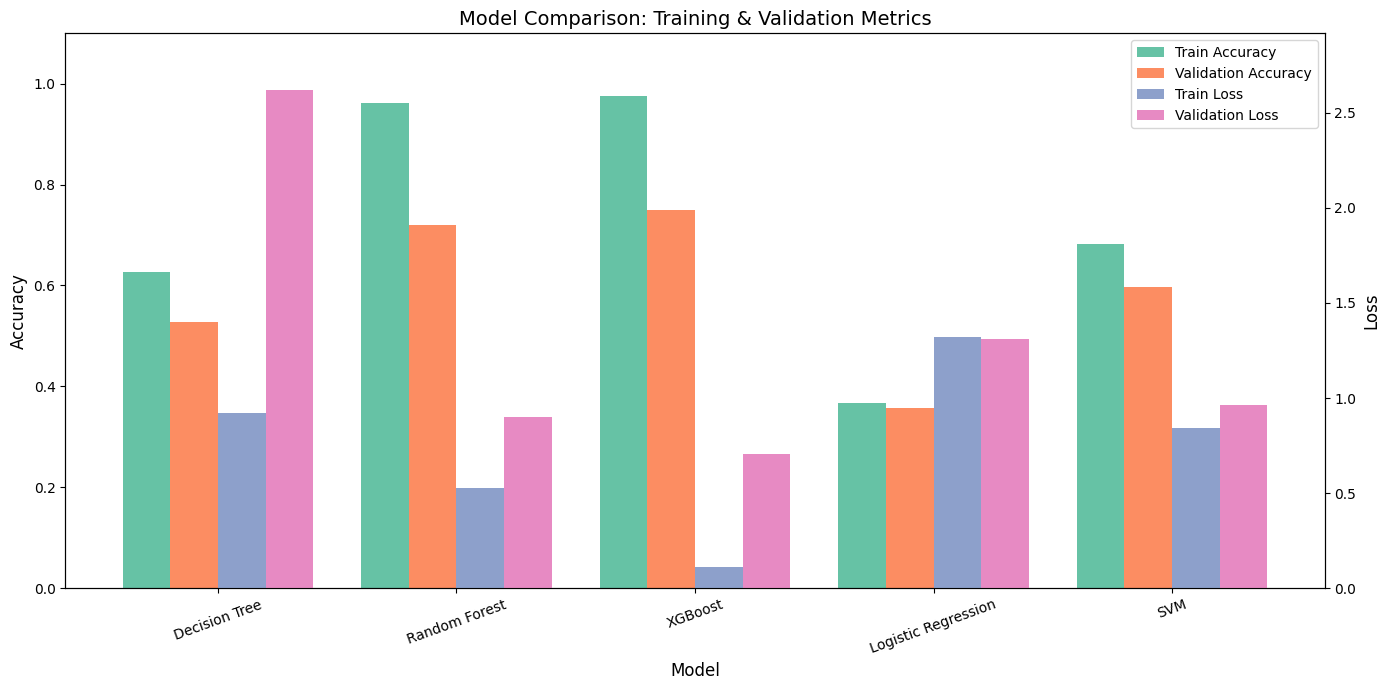

In [ ]:
# ===================== Visualization (auto from results_df) =====================

# Extract data directly from results_df
models = results_df['Model'].tolist()
train_acc = results_df['Average Training Accuracy'].tolist()
val_acc = results_df['Average Validation Accuracy'].tolist()
train_loss = results_df['Average Training Loss'].tolist()
val_loss = results_df['Average Validation Loss'].tolist()

# --- Combined Accuracy/Loss Bar Plot ---
x = np.arange(len(models))
width = 0.2
colors = sns.color_palette('Set2', 4)

fig, ax1 = plt.subplots(figsize=(14, 7))
ax2 = ax1.twinx()

# Accuracy bars (left axis)
ax1.bar(x - width, train_acc, width=width, label='Train Accuracy', color=colors[0])
ax1.bar(x, val_acc, width=width, label='Validation Accuracy', color=colors[1])

# Loss bars (right axis)
ax2.bar(x + width, train_loss, width=width, label='Train Loss', color=colors[2])
ax2.bar(x + 2*width, val_loss, width=width, label='Validation Loss', color=colors[3])

# Formatting
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12, color='black')
ax2.set_ylabel('Loss', fontsize=12, color='black')

ax1.set_xticks(x + width / 2)
ax1.set_xticklabels(models, rotation=20)

ax1.set_ylim(0, 1.1)
ax2.set_ylim(0, max(val_loss) + 0.3)

# Title and legend
ax1.set_title('Model Comparison: Training & Validation Metrics', fontsize=14)
bars1, labels1 = ax1.get_legend_handles_labels()
bars2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(bars1 + bars2, labels1 + labels2, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()


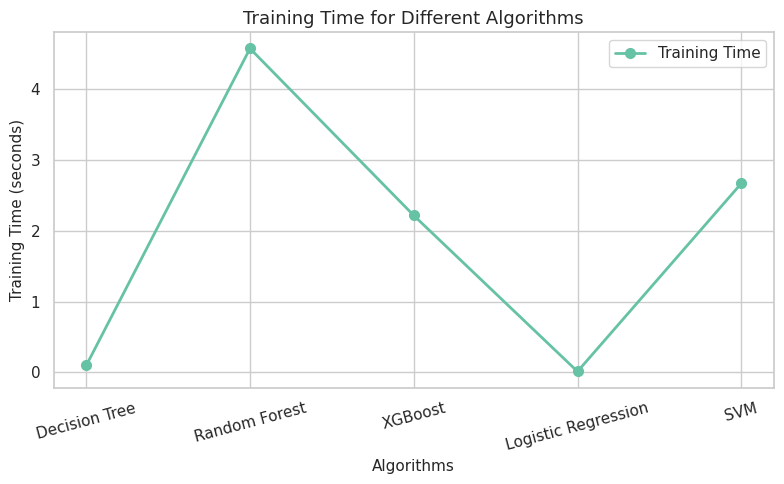

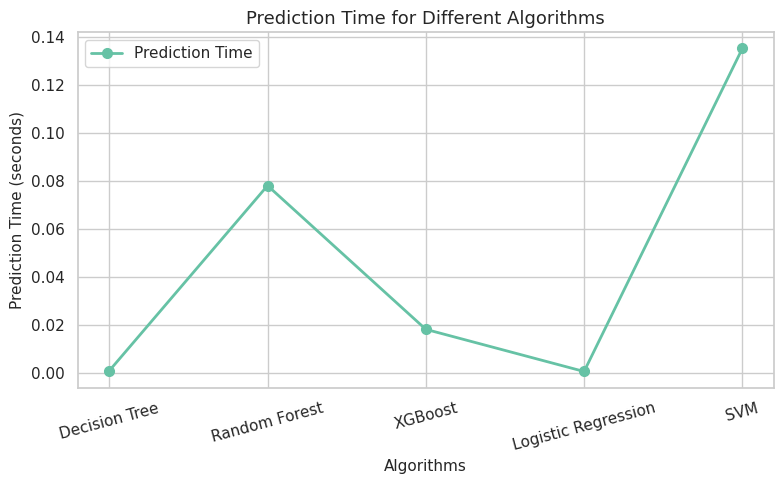

In [ ]:
# ===================== Training and Prediction Time Line Plots =====================
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid', palette='Set2')

# Extract from results_df
models_list = results_df['Model'].tolist()
train_times = results_df['Training Time (s)'].tolist()
predict_times = results_df['Inference Time (s)'].tolist()

# Convert into a format similar to your "sizes" logic
# Here we only have one value per model (not by dataset size)
# So we'll plot models on x-axis
x_labels = np.arange(len(models_list))

# --- Plot Training Time ---
plt.figure(figsize=(8, 5))
plt.plot(x_labels, train_times, marker='o', linewidth=2, markersize=7, label='Training Time')
plt.title("Training Time for Different Algorithms", fontsize=13)
plt.xlabel("Algorithms", fontsize=11)
plt.ylabel("Training Time (seconds)", fontsize=11)
plt.xticks(x_labels, models_list, rotation=15)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot Prediction Time ---
plt.figure(figsize=(8, 5))
plt.plot(x_labels, predict_times, marker='o', linewidth=2, markersize=7, label='Prediction Time')
plt.title("Prediction Time for Different Algorithms", fontsize=13)
plt.xlabel("Algorithms", fontsize=11)
plt.ylabel("Prediction Time (seconds)", fontsize=11)
plt.xticks(x_labels, models_list, rotation=15)
plt.legend()
plt.tight_layout()
plt.show()


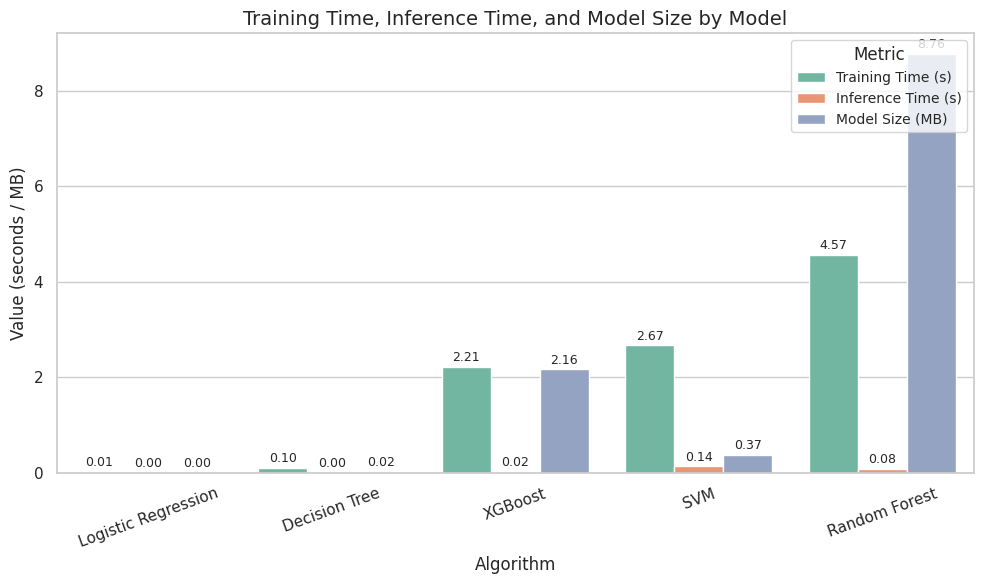

In [ ]:
# ===================== Grouped Vertical Bar Chart (with Labels) =====================
sns.set(style='whitegrid', palette='Set2')

# Ensure required columns exist in results_df
required_cols = ['Model', 'Training Time (s)', 'Inference Time (s)', 'Model Size (MB)']
available_cols = [col for col in required_cols if col in results_df.columns]

# Extract only available columns from results_df
summary_df = results_df[available_cols].copy()

# Melt into long format for grouped bar plotting
summary_melted = summary_df.melt(
    id_vars='Model',
    var_name='Metric',
    value_name='Value'
)

# Sort models by Training Time (or first available metric) for clarity
first_metric = [c for c in ['Training Time (s)', 'Inference Time (s)', 'Model Size (MB)'] if c in summary_df.columns][0]
summary_melted['Model'] = pd.Categorical(
    summary_melted['Model'],
    categories=summary_df.sort_values(by=first_metric)['Model'],
    ordered=True
)

# --- Plot ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=summary_melted,
    x='Model', y='Value', hue='Metric',
    palette='Set2'
)

# --- Add Labels to Bars ---
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9, padding=2)

# --- Formatting ---
plt.title("Training Time, Inference Time, and Model Size by Model", fontsize=14)
plt.xlabel("Algorithm", fontsize=12)
plt.ylabel("Value (seconds / MB)", fontsize=12)
plt.xticks(rotation=20)
plt.legend(title='Metric', loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


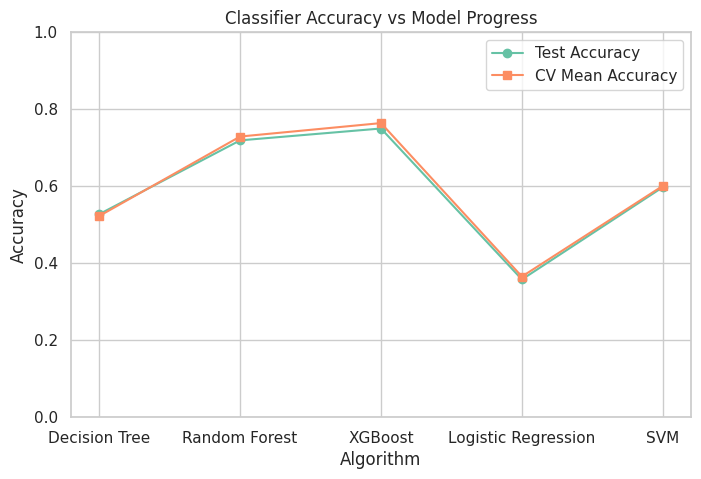

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(results_df['Model'], results_df['Test Accuracy'], marker='o', label='Test Accuracy')
plt.plot(results_df['Model'], results_df['Mean CV Accuracy'], marker='s', label='CV Mean Accuracy')
plt.title("Classifier Accuracy vs Model Progress")
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.legend()
plt.show()


📊 Distribution of Anemia Categories Before and After SMOTE


/tmp/ipython-input-2745561449.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.countplot(x=le_category.inverse_transform(y), palette='Set2')


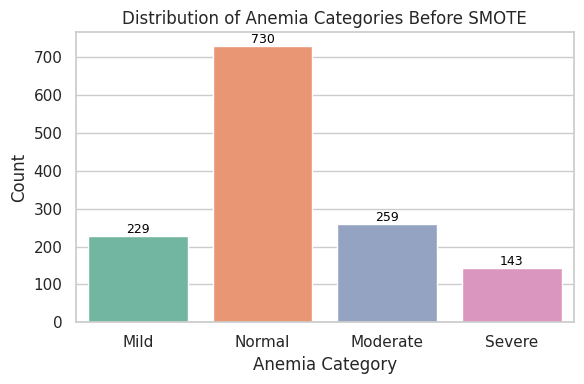

/tmp/ipython-input-2745561449.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(x=le_category.inverse_transform(y_res), palette='Set2')


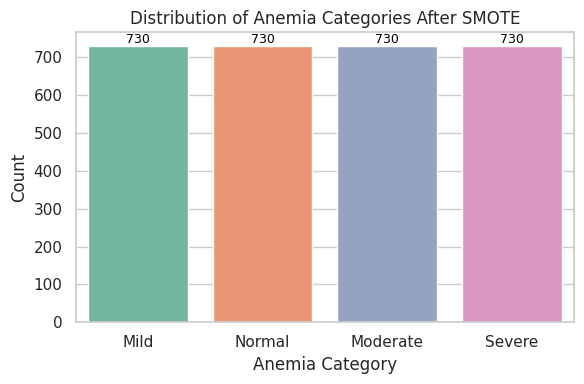

In [ ]:
# ===================== 6. Visualize Data After SMOTE =====================
print("\n📊 Distribution of Anemia Categories Before and After SMOTE")

# --- Before SMOTE ---
plt.figure(figsize=(6, 4))
ax1 = sns.countplot(x=le_category.inverse_transform(y), palette='Set2')
plt.title('Distribution of Anemia Categories Before SMOTE')
plt.xlabel('Anemia Category')
plt.ylabel('Count')

# Add count labels on top of each bar
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

# --- After SMOTE ---
plt.figure(figsize=(6, 4))
ax2 = sns.countplot(x=le_category.inverse_transform(y_res), palette='Set2')
plt.title('Distribution of Anemia Categories After SMOTE')
plt.xlabel('Anemia Category')
plt.ylabel('Count')

# Add count labels on top of each bar
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()



📊 Distribution of Anemia Categories in Training and Testing Sets


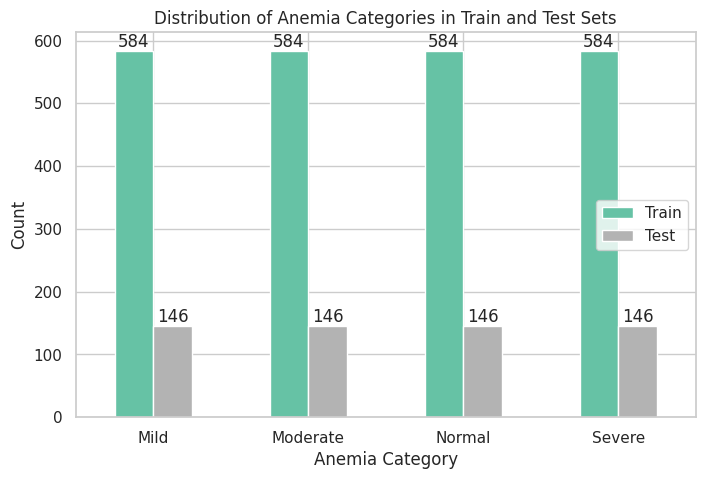

In [ ]:
# ===================== 7. Visualize Data Splitting =====================
print("\n📊 Distribution of Anemia Categories in Training and Testing Sets")

# Get class counts for training and testing sets
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

# Create labels for the categories
category_labels = le_category.inverse_transform(train_counts.index)

# Create a DataFrame for easier plotting
split_df = pd.DataFrame({
    'Category': category_labels,
    'Train': train_counts.values,
    'Test': test_counts.values
})

# Plotting
ax = split_df.set_index('Category').plot(kind='bar', figsize=(8, 5), colormap='Set2')
plt.title('Distribution of Anemia Categories in Train and Test Sets')
plt.xlabel('Anemia Category')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Add numbers on top of the bars
for container in ax.containers:
    ax.bar_label(container)

plt.show()

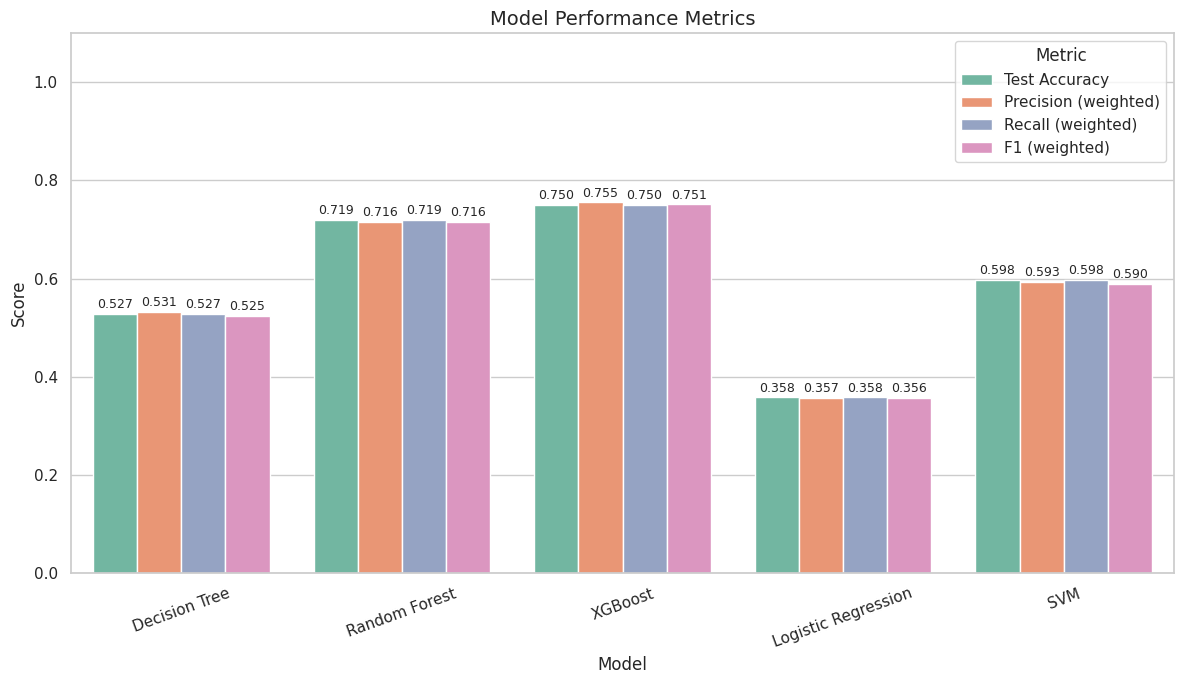

In [ ]:
# Ensure results_df is available
if 'results_df' not in globals():
    print("Error: results_df not found. Please run the model evaluation cell first.")
else:
    # Select the relevant columns
    performance_metrics = results_df[['Model', 'Test Accuracy', 'Precision (weighted)', 'Recall (weighted)', 'F1 (weighted)']].copy()

    # Melt the DataFrame for easier plotting
    performance_melted = performance_metrics.melt(
        id_vars='Model',
        var_name='Metric',
        value_name='Score'
    )

    # Plotting
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(
        data=performance_melted,
        x='Model',
        y='Score',
        hue='Metric',
        palette='Set2'
    )

    # Add value labels on top of the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=9, padding=2)

    plt.title("Model Performance Metrics", fontsize=14)
    plt.xlabel("Model", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.xticks(rotation=20)
    plt.ylim(0, 1.1) # Metrics are between 0 and 1
    plt.legend(title='Metric', loc='upper right')
    plt.tight_layout()
    plt.show()

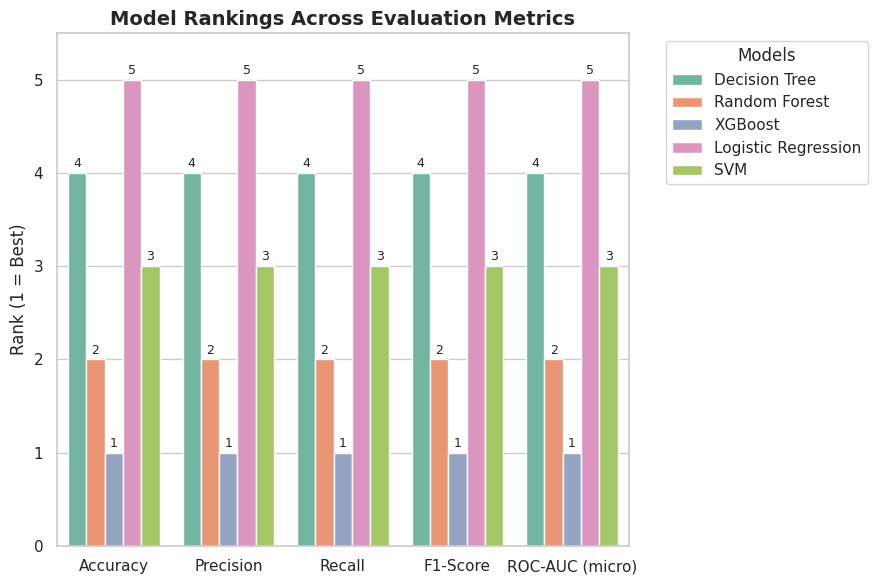

In [ ]:
# ===================== Model Rankings Across Evaluation Metrics (Including AUC-ROC) =====================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Ensure both results_df and auc_df exist ---
assert 'results_df' in locals(), "results_df not found. Please run the evaluation cell first."
assert 'auc_df' in locals(), "auc_df not found. Please run the ROC–AUC evaluation cell first."

# --- Select and rename columns from results_df ---
metrics_df = results_df[['Model',
                         'Average Validation Accuracy',
                         'Precision (weighted)',
                         'Recall (weighted)',
                         'F1 (weighted)']].copy()

metrics_df.rename(columns={
    'Average Validation Accuracy': 'Accuracy',
    'Precision (weighted)': 'Precision',
    'Recall (weighted)': 'Recall',
    'F1 (weighted)': 'F1-Score'
}, inplace=True)

# --- Merge with AUC–ROC (micro) results ---
merged_df = pd.merge(metrics_df, auc_df[['Model', 'ROC-AUC (micro)']], on='Model', how='left')

# --- Compute ranks (1 = best) ---
rank_df = merged_df.set_index('Model')
ranked = rank_df.rank(ascending=False, method='min').astype(int).reset_index()

# --- Melt for plotting ---
melted = ranked.melt(id_vars='Model', var_name='Metric', value_name='Rank')

# --- Plot setup ---
sns.set(style='whitegrid')
plt.figure(figsize=(9, 6))

# --- Grounded bar plot (bars start from 0) ---
ax = sns.barplot(data=melted, x='Metric', y='Rank', hue='Model', palette='Set2')

# --- Annotate ranks on bars ---
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9, padding=2)

# --- Formatting ---
plt.title('Model Rankings Across Evaluation Metrics', fontsize=14, weight='bold')
plt.ylabel('Rank (1 = Best)', fontsize=12)
plt.xlabel('')
plt.ylim(0, len(merged_df['Model']) + 0.5)  # bars start at ground (0)
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()
